### Summary

**독립변수와 종속변수가 범주형 데이터(거절/종종/항상,사용함/안함)에 가깝기 때문에 카이제곱검정을 사용하였다.  
카이제곱검정후 상관관계의 방향성을 판단하기 위해 pearson coefficient를 계산하였다.**

이용도에 따라 사용율에 연관성이 있는지 검정하기 위하여 카이제곱 검정을 실시한 결과,   
귀무가설에 대한 chi2 = 474.2942, p = 0.0000 로 유의수준 0.05보다 작으므로 귀무가설을 기각한다.  
즉, **이용도는 사용율에 영향을 준다** 

범주형 데이터에 대해 pearson coefficient를 계산하여 양의 상관관계(0.0301)을 얻었다.  
따라서 **더치페이 요청에 대한 응답률이 높을수록 더치페이 서비스를 더 많이 사용한다.**

추후 분석 및 검증을 위해 더미 변수도 정의하였다.

## 데이터 로드

In [1]:
import pandas as pd 
def conclusion(text):
    print(' => '+text+'\n')

def hist_text(series,left=0,right=1,bins=10):
    print(series.groupby(pd.cut(series, [(x/bins)*(right-left)+left for x in range(bins+1)],include_lowest=True)).count())

path = 'data/DS_사전과제_v2/'
df_c = pd.read_csv(path+'dutchpay_claim.csv')
df_c_det = pd.read_csv(path+'dutchpay_claim_detail.csv')
df_all = df_c_det.join(df_c.set_index('claim_id'), on='claim_id', how='left', sort=True)
df_all['claim_at'] = pd.to_datetime(df_all.claim_at)

print(df_all.columns)
conclusion(f'데이터 로드했음.')

Index(['claim_detail_id', 'claim_id', 'recv_user_id', 'claim_amount',
       'send_amount', 'status', 'claim_at', 'claim_user_id'],
      dtype='object')
 => 데이터 로드했음.



## 전처리

In [2]:
orig_size = len(df_c)#+len(df_c_det)
# 더치페이 요청 테이블 필터링 (자신에게만 더치페이 요청하는 경우 제외)
recv_count = df_c_det[df_c_det.status!='CHECK'].groupby('claim_id').count()['claim_detail_id']
valid_claim_ids = recv_count[recv_count>0].index
df_c = df_c[df_c.claim_id.isin(valid_claim_ids)]
# 더치페이 요청 상세 테이블 필터링 (0원 요청받은 경우 송금이 불가능 하기 때문에 제외)
df_c_det = df_c_det[df_c_det.claim_amount>0]
new_size = len(df_c)#+len(df_c_det)
# 추후 중복 데이터도 확인해보고 제거하면 좋을 것 같다.
conclusion(f'데이터 전처리. {orig_size}행 중 {orig_size-new_size}행 ({int(100*(1-new_size/orig_size))}%) 삭제됨.')

df_응답률 = pd.concat({
    '응답했던회수':df_c_det[df_c_det.status=='SEND'][['recv_user_id','claim_id']].groupby('recv_user_id').count()['claim_id'],
    '응답안한회수':df_c_det[df_c_det.status=='CLAIM'][['recv_user_id','claim_id']].groupby('recv_user_id').count()['claim_id'],
},axis=1)
df_응답률.fillna(0,inplace=True)
df_응답률['총회수'] = df_응답률.응답했던회수 + df_응답률.응답안한회수
df_응답률['응답률'] = df_응답률.응답했던회수 / df_응답률.총회수
print(df_응답률)
conclusion('''응답회수 집계함.''')

# conclusion('''총회수 자체가 작기 때문에 총회수 3 이하의 데이터를 제거하겠다.
# 총회수가 작은 경우 중요도에 비해 응답률이 너무 극단적이기 때문이다.
# 3을 선택한 이유는 추후 카테고리를 3개로 나눌 생각인데, 0.333 같이 경계에 걸리는 값을 없애기 위히서다.
# [주의] 총회수에 의한 selection bias를 추가하고 있다''')
# df_응답률 = df_응답률[df_응답률.총회수>3]
# print(df_응답률)

 => 데이터 전처리. 159194행 중 3191행 (2%) 삭제됨.

                 응답했던회수  응답안한회수   총회수       응답률
0001d33a536909b     1.0     2.0   3.0  0.333333
00020ba234abeaa     1.0     0.0   1.0  1.000000
0002cc3ae65fb5f     1.0     0.0   1.0  1.000000
0002f62e023caed     7.0     0.0   7.0  1.000000
00062c986178176     1.0     0.0   1.0  1.000000
...                 ...     ...   ...       ...
fffed49a18928b1     0.0     1.0   1.0  0.000000
fffeed613386500     0.0     1.0   1.0  0.000000
fffef842c35250b     0.0     1.0   1.0  0.000000
ffff6b7cec134f4     0.0     1.0   1.0  0.000000
fffff6ee97fbe6b     0.0    10.0  10.0  0.000000

[197474 rows x 4 columns]
 => 응답회수 집계함.



## 독립변수 설정

In [3]:
print('히스토그램 출력')
#df_응답률.응답률.hist()
hist_text(df_응답률.응답률, bins=10)
conclusion(f'''데이터 분포가 multimodal이다. 모르는 변수가 있는 것 같다.

(1)중복 데이터, (2)노이즈, (3)모집단의 bias등 여러가지 가능성이 있다.
문제가 발견되지 않는다면 고객이 실제로 이렇게 행동한다고 보고 적절한 모델을 생각해야 한다.

(1) 예를 들어 첫 송금시 여러 차례 중복 기록이 될 수도 있을 것이다. 그렇다면 신규 유입이 많아서 일어나는 현상이라고 해석할 수 있을 것이다.
그러나 중복 데이터라고 하기에는 신규 유입과 기존 고객간 송금 금액 편차 특성이 그렇게까지 극단적이지는 않다.
(각각 {
df_all[df_all.recv_user_id.isin(df_응답률[df_응답률.총회수<=5].index)].groupby('recv_user_id')['claim_amount'].std().mean()
:.2f}, {
df_all[df_all.recv_user_id.isin(df_응답률[df_응답률.총회수>5].index)].groupby('recv_user_id')['claim_amount'].std().mean()
:.2f}).

(2) 예를 들어 탈퇴회원이 문제라면 거절하는 시점에 패턴이 보여야 할텐데 그렇지 않았다.
봇등은 항상 극단적인 응답률을 보일 수 있다. 그러나 요청 금액과 맞지 않는 금액을 송금한 경우나 자주 송금한 경우는 적었다.

(3) {df_all.claim_at.min().strftime('%Y-%m-%d')} - {df_all.claim_at.max().strftime('%Y-%m-%d')} 기간내에 최소 1회 더치페이 요청을 받아 본 사람을 대상으로 데이터가 주어졌다.
random sampling이 아니므로, 만약 \'더이페이 요청을 받는 빈도\'와 \'응답률\'이 독립이 아니라면 잘못된 모집단 설정이다.
예를 들어, 차단 시스템이나 자동 수락 같은 시스템이 있다면, 당연히 더치페이 요청을 자주 받는 사람들은 극단적인 응답률을 보일 수 밖에 없다.
이 문제를 부분적으로 보강하려면, 더치페이 요청을 자주 받는 사람들과 그렇지 않은 사람들을 구분해서 각각에 대해 가설 검정을 하고, 결과가 일관성있게 나옴을 확인할 수 있다.
''')

print('데이터 분포 좀더 자세히 관찰 (구간별로 잘라보기)')
print('총회수 [1,1]')
hist_text(df_응답률[df_응답률.총회수==1].응답률, left=0, right=1, bins=5)
print('총회수 (1,5]')
hist_text(df_응답률[(1<df_응답률.총회수)&(df_응답률.총회수<=5)].응답률, left=0, right=1, bins=5)
print('총회수 (5,10]')
hist_text(df_응답률[(5<df_응답률.총회수)&(df_응답률.총회수<=10)].응답률, left=0, right=1, bins=5)
print('총회수 (10,inf)')
hist_text(df_응답률[(10<df_응답률.총회수)].응답률, left=0, right=1, bins=5)

conclusion('''\'총회수\'에 의해 \'응답률간\'의 분포 모양 자체가 바뀔 정도의 변화가 보이지는 않는다.
만약 특정 \'총회수\' 구간에서만 node가 보였다면, 그 데이터를 잘라서 따로 분석할 수 있었을 것이다.''')

conclusion('[독립변수] X : 고객의 성향을 통해 측정한 더치페이 응답률. [항상, 종종, 절대] 세개의 구간으로 나눈 카테고리 데이터.')

히스토그램 출력
응답률
(-0.001, 0.1]    121279
(0.1, 0.2]          160
(0.2, 0.3]          267
(0.3, 0.4]          748
(0.4, 0.5]         3876
(0.5, 0.6]          266
(0.6, 0.7]         1632
(0.7, 0.8]         1592
(0.8, 0.9]         1068
(0.9, 1.0]        66586
Name: 응답률, dtype: int64
 => 데이터 분포가 multimodal이다. 모르는 변수가 있는 것 같다.

(1)중복 데이터, (2)노이즈, (3)모집단의 bias등 여러가지 가능성이 있다.
문제가 발견되지 않는다면 고객이 실제로 이렇게 행동한다고 보고 적절한 모델을 생각해야 한다.

(1) 예를 들어 첫 송금시 여러 차례 중복 기록이 될 수도 있을 것이다. 그렇다면 신규 유입이 많아서 일어나는 현상이라고 해석할 수 있을 것이다.
그러나 중복 데이터라고 하기에는 신규 유입과 기존 고객간 송금 금액 편차 특성이 그렇게까지 극단적이지는 않다.
(각각 24951.58, 18819.59).

(2) 예를 들어 탈퇴회원이 문제라면 거절하는 시점에 패턴이 보여야 할텐데 그렇지 않았다.
봇등은 항상 극단적인 응답률을 보일 수 있다. 그러나 요청 금액과 맞지 않는 금액을 송금한 경우나 자주 송금한 경우는 적었다.

(3) 2019-12-01 - 2020-02-29 기간내에 최소 1회 더치페이 요청을 받아 본 사람을 대상으로 데이터가 주어졌다.
random sampling이 아니므로, 만약 '더이페이 요청을 받는 빈도'와 '응답률'이 독립이 아니라면 잘못된 모집단 설정이다.
예를 들어, 차단 시스템이나 자동 수락 같은 시스템이 있다면, 당연히 더치페이 요청을 자주 받는 사람들은 극단적인 응답률을 보일 수 밖에 없다.
이 문제를 부분적으로 보강하려면, 더치페이 요청을 자주 받는 사람들과 그렇지 않은 사람들을 구분해서 각

## 종속변수 설정

In [4]:
df_더치사용횟수 = df_c.groupby('claim_user_id')['claim_id'].count()
df_더치사용안함 = pd.Series(0, index= list(set(df_c_det.recv_user_id.unique())-set(df_c.claim_user_id.unique())))
df_더치사용 = pd.concat([ df_더치사용횟수, df_더치사용안함 ])
hist_text(df_더치사용, left=0, right=df_더치사용.max())

df = pd.concat([
    df_더치사용.value_counts().sort_index(),
    pd.Series([int(26000*x**-1.5) for x in range(1,120)], index=range(1,120)).rename('ref')
],axis=1)
print(df.head())
conclusion('-1.5승 polinomial distribution을 따르는 것 같다. transform 하기에는 너무 skew 되어 있음')

conclusion('[종속변수] Y : 기간 내 더치페이를 요청한 적이 있는지 여부를 통해 측정한 더치페이 이용도. 카테고리 데이터.')

(-0.001, 12.0]    236423
(12.0, 24.0]        1339
(24.0, 36.0]         256
(36.0, 48.0]          60
(48.0, 60.0]          16
(60.0, 72.0]           3
(72.0, 84.0]           4
(84.0, 96.0]           0
(96.0, 108.0]          1
(108.0, 120.0]         2
dtype: int64
          0      ref
0  186147.0      NaN
1   25867.0  26000.0
2    9326.0   9192.0
3    4990.0   5003.0
4    2995.0   3250.0
 => -1.5승 polinomial distribution을 따르는 것 같다. transform 하기에는 너무 skew 되어 있음

 => [종속변수] Y : 기간 내 더치페이를 요청한 적이 있는지 여부를 통해 측정한 더치페이 이용도. 카테고리 데이터.



### 문제 정의

In [5]:
conclusion('''
독립변수와 종속변수가 범주형 데이터이기 때문에 카이제곱검정을 사용하겠다.''')
conclusion('''
[모집단] 주어진 기간 내에 더치페이 요청을 받아본 사람 (요청을 하기만 하고 받지 않은 사람은 응답률을 정의할 수 없어서 제외)
[독립변수] X : 더치페이 응답률. [항상, 종종, 절대]
[종속변수] Y : 더치페이 이용도. [더치사용, 사용안함]''')
conclusion('''
[통계기법 1] : X와 Y의 관계 여부를 알아보기 위해 카이제곱 검정 이용
H0 : 응답률와 이용도는 독립이다
H1 : 응답률에 따라 이용도에 차이가 있다
유의수준 : 0.05''')
# print('중심극한정리')
# from scipy import stats
# Xs_of_random_subset = [df_응답률.sample(frac=0.1).응답률.map(lambda x:x>0).sum() for tmp in range(1000)]
# print(stats.shapiro(Xs_of_random_subset))
# conclusion('무작위 샘플링을 하면 항상 정규분포가 나오므로. 카이제곱을 사용할 수 있다.')
conclusion('''
[통계기법 2] : X와 Y간의 상관관계가 있다면, 방향을 파악하기 위해 phi coefficient(=pearson correlation) 계산''')

 => 
독립변수와 종속변수가 범주형 데이터이기 때문에 카이제곱검정을 사용하겠다.

 => 
[모집단] 주어진 기간 내에 더치페이 요청을 받아본 사람 (요청을 하기만 하고 받지 않은 사람은 응답률을 정의할 수 없어서 제외)
[독립변수] X : 더치페이 응답률. [항상, 종종, 절대]
[종속변수] Y : 더치페이 이용도. [더치사용, 사용안함]

 => 
[통계기법 1] : X와 Y의 관계 여부를 알아보기 위해 카이제곱 검정 이용
H0 : 응답률와 이용도는 독립이다
H1 : 응답률에 따라 이용도에 차이가 있다
유의수준 : 0.05

 => 
[통계기법 2] : X와 Y간의 상관관계가 있다면, 방향을 파악하기 위해 phi coefficient(=pearson correlation) 계산



### 카이제곱 검정

In [6]:
from scipy.stats import chi2_contingency
import numpy as np

def df_pretty_print(df):
    df_print = df.copy()
    df_print['합계'] = df_print.sum(axis=1)
    df_print = df_print.T
    df_print['합계'] = df_print.sum(axis=1)
    df_print['비율'] = df_print['더치사용']/df_print['합계']
    df_print = df_print.T
    pd.options.display
    print(df_print)

cond_필터 = (df_응답률.총회수>0)

cond_항상 = (df_응답률.응답률==1.0)
cond_종종 = (0.0<df_응답률.응답률) & (df_응답률.응답률<1.0)
cond_절대 = (0.0==df_응답률.응답률)

uid_항상 = set( df_응답률[ cond_필터 & cond_항상 ].index )
uid_종종 = set( df_응답률[ cond_필터 & cond_종종 ].index )
uid_절대 = set( df_응답률[ cond_필터 & cond_절대 ].index )

uid_더치사용 = set( df_c.claim_user_id )

print('분할표')
df = pd.DataFrame( 
    [
        [len(uid_항상 & uid_더치사용),len(uid_종종 & uid_더치사용),len(uid_절대 & uid_더치사용)],
        [len(uid_항상 - uid_더치사용),len(uid_종종 - uid_더치사용),len(uid_절대 - uid_더치사용)],
    ], 
    columns=['절대', '항상', '종종'],
    index=['더치사용', '더치안함']
)
df_pretty_print(df[['절대', '항상', '종종']])
conclusion('분할표를 작성하였다')


chi2, p, dof, expctd = chi2_contingency(df[['절대', '항상', '종종']])

print(f'''expected: {expctd}
chi2: {chi2:.4f},
p: {p:.4f}
dof: {dof:.4f}''')

phi =  \
(df.values[0,0]*df.values[1,2] - df.values[0,2]*df.values[1,0]) \
/(df.values[0,0]+df.values[0,2])**0.5 \
/(df.values[1,0]+df.values[1,2])**0.5 \
/(df.values[0,0]+df.values[1,0])**0.5 \
/(df.values[0,2]+df.values[1,2])**0.5 

df_pearson = pd.DataFrame(index=df_응답률.index)
df_pearson['응답률'] = cond_항상*1 + cond_절대*0
df_pearson['사용률'] = df_pearson.index.isin(uid_더치사용)*1
df_pearson = df_pearson[cond_종종 == False]
pearson_binary = df_pearson.corr().values[0,1]

df_pearson = pd.DataFrame(index=df_응답률.index)
df_pearson['응답률'] = cond_항상*1 + cond_절대*(-1) + cond_종종*0
df_pearson['사용률'] = df_pearson.index.isin(uid_더치사용)*1
pearson = df_pearson.corr().values[0,1]

print(f'''Phi coefficient(binary pearson) = {phi:.4f} (응답률 \'종종\'을 제외)
pearson coefficient: {pearson:.4f} (\'항상\'=1, \'종종\'=0, \'절대\'=-1)''')

conclusion(f'''이용도에 따라 사용율에 연관성이 있는지 검정하기 위하여 카이제곱 검정을 실시한 결과, 
귀무가설에 대한 chi2 = {chi2:.4f}, p = {p:.2e} 로 유의수준 0.05보다 작으므로 귀무가설을 기각한다.
즉, 이용도는 사용율에 영향을 준다.
범주형 데이터에 대해 pearson coefficient를 계산하여 양의 상관관계({pearson:.4f})을 얻었다.
따라서 더치페이 요청에 대한 응답률이 높을수록 더치페이 서비스를 더 많이 사용한다.''')

cond_더미1 = (df_응답률.index.map(lambda x:x[-1]<'8').values)
cond_더미2 = (df_응답률.index.map(lambda x:x[-2]<'4').values)
cond_더미3 = (df_응답률.index.map(lambda x:x[-3]<'2').values)

uid_더미1 = set( df_응답률[ cond_필터 & cond_더미1 ].index )
uid_더미2 = set( df_응답률[ cond_필터 & cond_더미2 ].index )
uid_더미3 = set( df_응답률[ cond_필터 & cond_더미3 ].index )

uid_더치사용 = set( df_c.claim_user_id )
df = pd.DataFrame( 
    [
        [len(uid_더미1 & uid_더치사용),len(uid_더미2 & uid_더치사용),len(uid_더미3 & uid_더치사용)],
        [len(uid_더미1 - uid_더치사용),len(uid_더미2 - uid_더치사용),len(uid_더미3 - uid_더치사용)],
    ], 
    columns=['더미1', '더미2', '더미3'],
    index=['더치사용', '더치안함']
)

chi2, p, dof, expctd = chi2_contingency(df[['더미1', '더미2', '더미3']])
#conclusion(f'''추후 분석을 위해 더미 변수를 정의하였다.''')

분할표
                절대            항상             종종             합계
더치사용   4711.000000   1079.000000    6889.000000   12679.000000
더치안함  61443.000000   8984.000000  114368.000000  184795.000000
합계    66154.000000  10063.000000  121257.000000  197474.000000
비율        0.071213      0.107224       0.056813       0.064206
 => 분할표를 작성하였다

expected: [[  4247.47848324    646.1041808    7785.41733595]
 [ 61906.52151676   9416.8958192  113471.58266405]]
chi2: 474.2942,
p: 0.0000
dof: 2.0000
Phi coefficient(binary pearson) = 0.0286 (응답률 '종종'을 제외)
pearson coefficient: 0.0301 ('항상'=1, '종종'=0, '절대'=-1)
 => 이용도에 따라 사용율에 연관성이 있는지 검정하기 위하여 카이제곱 검정을 실시한 결과, 
귀무가설에 대한 chi2 = 474.2942, p = 1.02e-103 로 유의수준 0.05보다 작으므로 귀무가설을 기각한다.
즉, 이용도는 사용율에 영향을 준다.
범주형 데이터에 대해 pearson coefficient를 계산하여 양의 상관관계(0.0301)을 얻었다.
따라서 더치페이 요청에 대한 응답률이 높을수록 더치페이 서비스를 더 많이 사용한다.



## Appendix
### Data Inspection

In [7]:
import pandas as pd

path = 'data/DS_사전과제_v2/'
df_c = pd.read_csv(path+'dutchpay_claim.csv')
df_c_det = pd.read_csv(path+'dutchpay_claim_detail.csv')
df_all = df_c_det.join(df_c.set_index('claim_id'), on='claim_id', how='left', sort=True)

def test(question, df):
    print(f'{question} ... {"YES" if df.size>0 else "NO"}')

def conclusion(text):
    print(' => '+text+'\n')

In [8]:
# Number logic check
df = df_c_det.set_index(['claim_id','claim_detail_id'])

test('Users can request or send negative amount', df[(df.claim_amount<0) | (df.send_amount<0)])
conclusion('음수 송금은 불가능')

test('Request to self and pay manually', df_all[(df_all.recv_user_id == df_all.claim_user_id) & (df_all.send_amount!=df_all.claim_amount)])
conclusion('더치페이 요청할 때 자신을 넣으면 항상 send_amount=claim_amount로 자동 처리된다.')

test('Users can make request with claim_amount=0', df[df.claim_amount==0])
test('claim_user can send_amount==0', df_all[ (df_all.recv_user_id == df_all.claim_user_id) & (df_all.send_amount==0) ] )
test('recv_user can send_amount==0', df_all[ (df_all.recv_user_id != df_all.claim_user_id) & (df_all.send_amount==0) ] )
conclusion('0원 더치페이 요청은 가능하지만 0원 송금은 불가능하다. 자기 자신인 경우 자동 처리되는 경우 예외.')

test('Data contains non-dutchpay transfer cases', df[df.send_amount.notna() & df.claim_amount.isna()])
test('Users can send less than claim_amount', df[df.send_amount<df.claim_amount])
test('Users can send more than claim_amount', df[df.send_amount>df.claim_amount])
conclusion('요청 금액과 송금 금액이 다를 수 있다')


Users can request or send negative amount ... NO
 => 음수 송금은 불가능

Request to self and pay manually ... NO
 => 더치페이 요청할 때 자신을 넣으면 항상 send_amount=claim_amount로 자동 처리된다.

Users can make request with claim_amount=0 ... YES
claim_user can send_amount==0 ... YES
recv_user can send_amount==0 ... NO
 => 0원 더치페이 요청은 가능하지만 0원 송금은 불가능하다. 자기 자신인 경우 자동 처리되는 경우 예외.

Data contains non-dutchpay transfer cases ... NO
Users can send less than claim_amount ... YES
Users can send more than claim_amount ... YES
 => 요청 금액과 송금 금액이 다를 수 있다



In [9]:
# Status logic check
df = df_all
print( 'Status=\'CHECK\' logic ...', (df.status=='CHECK').equals( df.recv_user_id==df.claim_user_id) ) # dutchpay maker
print( 'Status=\'CLAIM\' logic ...', (df.status=='CLAIM').equals( df.send_amount.isna() ) ) # dutchpay potential taker
print( 'Status=\'SEND\' logic ...', (df.status=='SEND').equals( df.send_amount.notna() & (df.status!='CHECK') ) ) # dutchpay taker
conclusion('CHECK는 더치페이 제안한 사람이 스스로를 지목한 경우, CLAIM은 지목받고 결제 안 한 경우, SEND는 0원 이상 송금한 사람을 의미한다')

Status='CHECK' logic ... True
Status='CLAIM' logic ... True
Status='SEND' logic ... True
 => CHECK는 더치페이 제안한 사람이 스스로를 지목한 경우, CLAIM은 지목받고 결제 안 한 경우, SEND는 0원 이상 송금한 사람을 의미한다



In [10]:
# More Logic Check
print( '1-1 relationship of claim_id ...', set(df_c.claim_id.unique()) == set(df_c_det.claim_id.unique()) )
test( 'Sometimes, base info exists but there\'s no detail info', df_c[~df_c.claim_id.isin(df_c_det.claim_id)] )
test( 'Sometimes, detail info exists but there\'s no base info', df_c_det[~df_c_det.claim_id.isin(df_c.claim_id)] )

conclusion(f'Don\'t know why this happens, but it happens only {df_c[~df_c.claim_id.isin(df_c_det.claim_id)].shape[0]} times')

1-1 relationship of claim_id ... False
Sometimes, base info exists but there's no detail info ... YES
Sometimes, detail info exists but there's no base info ... NO
 => Don't know why this happens, but it happens only 140 times



       recv_user_id                      
status        CHECK      CLAIM       SEND
min        0.000000   0.000000   0.000000
mean       0.931809   1.607196   0.966999
max        1.000000  44.000000  35.000000
 => 평균 3.5명이 더치페이를 하는데, 주최자 제외 1명 정도가 더치페이에 응한다

count    241283.000000
mean          2.311162
std           3.641488
min           1.000000
0%            1.000000
50%           1.000000
70%           2.000000
90%           5.000000
max         157.000000
Name: record per recv_user_id, dtype: float64
2019-12-01 00:01:09 ... 2020-02-29 23:59:59


<AxesSubplot:>

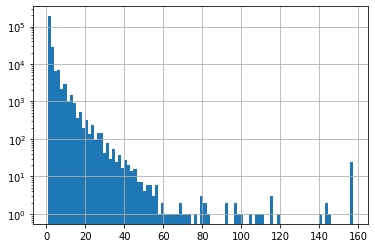

In [11]:
# Distribution Check
df = df_all
df_pivot = df.pivot( index=['claim_id','claim_detail_id'], columns='status', values=['recv_user_id'])
print( df_pivot.groupby(level=0).count().describe().loc()[['min','mean','max']] )
conclusion('평균 3.5명이 더치페이를 하는데, 주최자 제외 1명 정도가 더치페이에 응한다')

print( df.groupby('recv_user_id')['claim_detail_id'].count().rename('record per recv_user_id').describe(percentiles=[0,0.5,0.7,0.9])) 
print( df.claim_at.min(), '...', df.claim_at.max() )
df.groupby('recv_user_id')['claim_detail_id'].count().hist(log=True, bins=100)

더치페이 신규 사용자가 너무 많기 때문에 더치페이의 홍보 효과가 실제로는 큰데도 상대적으로 묻힐 수 있어 유의해야 한다.